In [1]:
import matplotlib.pylab as plt
import tensorflow as tf
import numpy as np
from PIL import Image
import os

%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 10)

https://www.kaggle.com/c/dogs-vs-cats/data

In [2]:
train_path = 'dogcat_data/train/'
train_image_list = np.array(os.listdir(train_path))

In [3]:
test_path = 'dogcat_data/test1/'
test_image_list = np.array(os.listdir(test_path))

In [4]:
class Batch:
    """
    TODO
    """
    def __init__(self, image_list, batch_size=128):
        self.i = 0
        self.n = len(image_list)
        self.image_list = image_list
        self.batch_size = batch_size

    def __iter__(self):
        return self
    
    def next(self):
        idxs = np.random.randint(0, len(self.image_list), size=self.batch_size)
        return self.image_list[idxs] 
    
def open_images(image_list, path='', shape=(50, 50)):
    """
    TODO
    """
    data = []
    labels = []
    for fname in image_list:
#         img = np.asarray(Image.open(os.path.join(path, fname)))
#         y, x, z = img.shape
#         if y-shape[0] <= 0 or x-shape[1] <= 0:
#             continue
        
        if 'cat' in fname:
            labels.append(1)
        else:
            labels.append(0)
# #         import pdb; pdb.set_trace()
#         try:
#             rnd_x = np.random.randint(0, x - shape[1])
#         except:
#             import pdb;pdb.set_trace()
#         try:
#             rnd_y = np.random.randint(0, y - shape[0])
#         except:
#             import pdb;pdb.set_trace()
        
#         smpl_img = img[rnd_y: rnd_y+shape[1], rnd_x: rnd_x+shape[0], :]
        img = Image.open(os.path.join(path, fname))
        img = img.resize((shape[0], shape[1]), Image.ANTIALIAS)
        smpl_img = np.asarray(img)
        data.append(smpl_img)
    
    labels = np.array(labels)
    cats = labels == 1
    dogs = labels == 0
    labels = np.array(np.stack((cats, dogs), axis=1), dtype=int)
#     import pdb;pdb.set_trace()
    return np.array(data), labels
        

In [5]:
## parameters
learning_rate = 0.1
train_iter = 5000 ## raise for more train accuracy ## 25000
batch_size = 50

## CNN parameters
img_shape = (120, 120)
# n_input = 50*50 ## Going to only take random 50x50 chunks of every image
n_labels = 2 ## or 2 labels (cat, dog)
dropout = 0.75 ## prob to keep, may change later

In [6]:
def conv2d(x, W, b, strides=1):
    """
    Performs the 2d convolution, adds the bias and does the relu.
    
    Parameters
    ----------
    x: tf.placeholder
    W: tf.variable
    b: tf.variable
    strides: int
    
    Returns
    -------
    x: tf.placeholder
        convolution with layer weights and bias added
    """
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding="SAME")
    return tf.nn.relu(x + b) ## add the bias and take the relu


def maxpool2d(x, k=2):
    """
    Pool the data after it has been convolved. This will downsample the
    image by k. If k is 2 then a 28x28 will be a 14x14 image.
    
    Parameters
    ----------
    x: tf.placeholder
    k: int
    
    Returns
    -------
    x: tf.placeholder
        convolution layer
    """
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], 
                              strides=[1, k, k, 1],
                              padding='SAME')


def cnn(x, W, b, dropout, img_shape=(28, 28)):
    """
    The convolutional neural network. Takes your data, weights, biases
    and dropout. All of these need to be TensorFlow variables or
    placeholders. To avoid have a bunch of arguments, pass the weights
    and biases for each layer in in dictionaries with keys
    
    0 - first layer
    1 - second layer
    fc - full connected layer
    out - output layer
    parity_out - parity output layer (odd/even label)
    
    This function will alter the final layer to allow us to predict the
    oddness/evenness (parity) of the integer. I will also keep the integer
    classification to train on, then with little training we can use
    the upstream layers to predict the parity. We can then just later 
    optimize on the finaly 'parity_out' layer to get the classification
    for odd or even.
    
    Parameters
    ----------
    x : tf.placeholder
    W : dictionary of tf.variables (keys above)
    b : dictionary of tf.variables (keys above)
    dropout: tf.placeholder
    img_shape: tuple
    
    Returns
    -------
    pred: tf method to get the predicitons for the digit.
    parity_pred: tf method to get the predicitons for the parity. 
    """
    
    ## reshape the data out of the matrix 
    ## so we can apply the 2d convolution to each
#     x = tf.reshape(x, shape=[-1, img_shape[0], img_shape[1], 1])
    
    ## convolve and pool for the first layer, downsample by 2
    conv1 = conv2d(x, W['0'], b['0'])
    conv1 = maxpool2d(conv1, k=2)
    
    ## convolve and pool for the second layer, downsample by 2
    conv2 = conv2d(conv1, W['1'], b['1'])
    conv2 = maxpool2d(conv2, k=2)
    
    ## convolve and pool for the third layer, downsample by 2
    conv3 = conv2d(conv2, W['2'], b['2'])
    conv3 = maxpool2d(conv3, k=2)
    
    ## convolve and pool for the third layer, downsample by 2
    conv4 = conv2d(conv3, W['3'], b['3'])
    conv4 = maxpool2d(conv4, k=2)

    ## create the fully connected layer, and reshape the 
    ## second conv layer
    print(W['fc'].get_shape())
    print(conv3.get_shape())
    fc = tf.reshape(conv4, [-1, W['fc'].get_shape().as_list()[0]])
#     fc = tf.reshape(conv3, [-1, W['fc'].get_shape()[0]])
    fc = tf.add(tf.matmul(fc, W['fc']), b['fc'])
    fc = tf.nn.relu(fc)
    
    ## apply the dropout
    fc = tf.nn.dropout(fc, dropout)
    
    ## evaluate the final layer that gives the prediction for the
    ## class
    pred = tf.matmul(fc, W['out']) + b['out']
    
    return pred

In [7]:
## placeholders
x = tf.placeholder(tf.float32, [None, img_shape[0], img_shape[1], 3])
y = tf.placeholder(tf.float32, [None, n_labels])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

# ## CNN weights and biases
# weights = {
#     # 3x3 conv, 3 (rgb) input, 10 features output
#     '0': tf.Variable(tf.random_normal([3, 3, 3, 10])),
#     # 3x3 conv, 10 inputs, 20 features output
#     '1': tf.Variable(tf.random_normal([3, 3, 10, 20])),
#     # 3x3 conv, 10 inputs, 20 features output
#     '2': tf.Variable(tf.random_normal([3, 3, 20, 40])),
#     # fully connected, 6*6*40 inputs, 1024 outputs 
#     # 50x50 --> 7x7
#     # 100x100 --> 13x13
#     # 120x120 --> 15
#     'fc': tf.Variable(tf.random_normal([15*15*40, 1024])),
#     # 1024 inputs, 2 outputs (class prediction)
#     'out': tf.Variable(tf.random_normal([1024, n_labels]))
# }

# biases = {
#     '0': tf.Variable(tf.random_normal([10])),
#     '1': tf.Variable(tf.random_normal([20])),
#     '2': tf.Variable(tf.random_normal([40])), 
#     'fc': tf.Variable(tf.random_normal([1024])),
#     'out': tf.Variable(tf.random_normal([n_labels])),
# }


## CNN weights and biases
weights = {
    # 3x3 conv, 3 (rgb) input, 10 features output
    '0': tf.Variable(tf.random_normal([3, 3, 3, 32])),
    # 3x3 conv, 10 inputs, 20 features output
    '1': tf.Variable(tf.random_normal([3, 3, 32, 64])),
    # 3x3 conv, 10 inputs, 20 features output
    '2': tf.Variable(tf.random_normal([3, 3, 64, 128])),
    # 3x3 conv, 10 inputs, 20 features output
    '3': tf.Variable(tf.random_normal([3, 3, 128, 256])),
    # fully connected, 6*6*40 inputs, 1024 outputs 
    # 50x50 --> 7x7
    # 100x100 --> 13x13
    # 120x120 --> 15
    'fc': tf.Variable(tf.random_normal([8*8*256, 1024])),
    # 1024 inputs, 2 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_labels]))
}

biases = {
    '0': tf.Variable(tf.random_normal([32])),
    '1': tf.Variable(tf.random_normal([64])),
    '2': tf.Variable(tf.random_normal([128])),
    '3': tf.Variable(tf.random_normal([256])),
    'fc': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_labels])),
}

In [8]:
## Construct model
pred = cnn(x, weights, biases, keep_prob, img_shape=img_shape)

## Define loss and optimizer 
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## functions to get the labels out
ypred = tf.argmax(pred, 1)

(16384, 1024)
(?, 15, 15, 128)


In [9]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

batch = Batch(train_image_list, batch_size)

step = 1
while step*batch_size < train_iter:
    ## get a batch of data -- use built in next_batch function
    batch_img_names = batch.next()
    
    bx, by = open_images(batch_img_names, path=train_path, shape=img_shape)
#     import pdb;pdb.set_trace()
    ## call the optimizer function. This knows about the functions up-
    ## stream and will update variables we just need to pass in the 
    ## placeholders or in this case training data and dropout
    ## this is where the training happens. All weights and biases are updated here.
    sess.run(optimizer, feed_dict={x: bx, y: by, keep_prob: 1.})
    
    ## print the accuracy mod 10 steps
    if step % 10 == 0:
        acc = sess.run(accuracy, feed_dict={x: bx, y: by, keep_prob: 1.})
        print("Iteration : {}, Training Accuracy: {}".format(step*batch_size, acc))
    
    step += 1
acc = sess.run(accuracy, feed_dict={x: bx, y: by, keep_prob: 1.})
print("Iteration : {}, Training Accuracy: {}".format(step*batch_size, acc))

Iteration : 500, Training Accuracy: 0.5199999809265137
Iteration : 1000, Training Accuracy: 0.4000000059604645
Iteration : 1500, Training Accuracy: 0.36000001430511475
Iteration : 2000, Training Accuracy: 0.5400000214576721
Iteration : 2500, Training Accuracy: 0.47999998927116394
Iteration : 3000, Training Accuracy: 0.5
Iteration : 3500, Training Accuracy: 0.47999998927116394
Iteration : 4000, Training Accuracy: 0.6000000238418579
Iteration : 4500, Training Accuracy: 0.5400000214576721


In [10]:
128*2

256

In [11]:
img = Image.open('dogcat_data/train/cat.0.jpg')
new_width = 128
new_height = 128
img = img.resize((new_width, new_height), Image.ANTIALIAS)

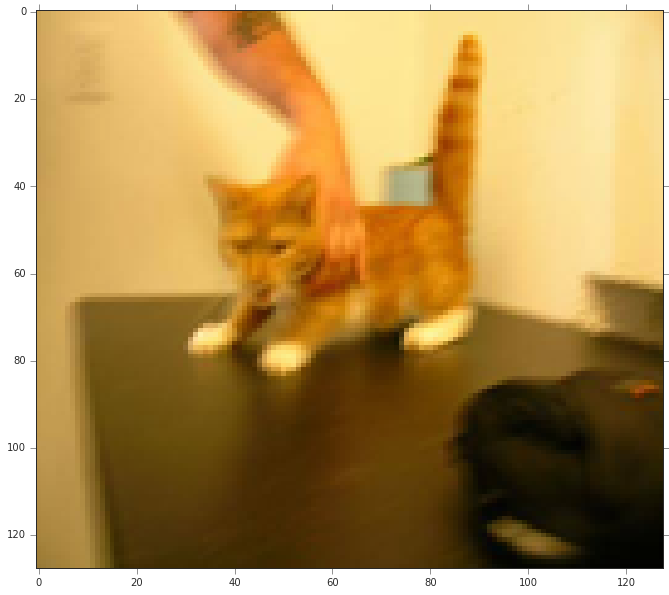

In [12]:
plt.imshow(img)